# Kiva dataset exploration

## Introduction
Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people. In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.

Kiva has provided a dataset of loans issued over the last two years, and participants are invited to use this data as well as source external public datasets to help Kiva build models for assessing borrower welfare levels.

More on the data and task can be found on [Kaggle](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/home)

I will use these data to practice my data science skills, especially with Pandas, matplotlib, scikit and, eventually, I'll build a Deep Learning Model.

## Goals
The following questions will try to be answered.
 + How is the total amount of spent? Which country receive the biggest amount on loan? Which type of projects are most funded? And within the most funded countries?
 + How is the money spread relative to the MPI?
 + What kind of features are most present for a loan (gender, group, ...), and if available, which ones are the most likely funded (haven't founded accepted / refused loan data yet)?
 + What trend are the lending trends?
 + Eventually writing a loan request generator just because reasons.
 
## Plan
We'll attack the problem by first exploring the data files on by one (on this document). Next we'll try answering the above questions on separated notebooks:
 + [How is the amount of loan spent?](http://localhost:8888/notebooks/01%20Loans%20by%20country%20exploration.ipynb)

## Exploring Kiva's Data
Let's introduce quickly the available files.
 + *kiva_loans.csv* (671K x 20) contains details loan informations.
 + *kiva_mpi_region_locations.csv* (2773 x 9) contains MPI (Global Multidimensional Poverty Index) by location and region.
 + *loan_theme_ids.csv* (779K x 4) Loan themes by ID
 + *loan_themes_by_region.csv* (15.7K x 21) Loan themes by region
 
## kiva_loans
### What's inside?

In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [160]:
kldf = pd.read_csv("data/02-kiva/kiva_loans.csv",index_col=0)
kldf.head()

,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
id,,,,,,,,,,,,,,,,,,,
653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


All the loans are fully funded with no information on potential refused / not through loans. No information on if / when the loans where reimbursed so far. Useful information for what I want are loan_amount, activity, use, country and borrower gender. We could use this to find where the money is spent and on what type of activites. Note the gender column asks for a bit of postprocessing to discover groups and gender biases. Posted time combined with sector and activity can help finding general and country specific trends.

### Is all the money transfered to the borrower?

I'd like to see when if at any moment there is a difference between loan_amount and funded_amount which would mean that some of the money is lost somewhere.

In [6]:
mask = kldf["funded_amount"] != kldf["loan_amount"]
kldf[mask].head()

,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
id,,,,,,,,,,,,,,,,,,,
653261,4275.0,5000.0,Personal Housing Expenses,Housing,"to pave the ground and repair the ceiling, to ...",PS,Palestine,jenin,USD,122.0,2014-01-02 09:53:45+00:00,2013-12-24 08:00:00+00:00,NaN,39.0,58,"#Supporting Family, #Interesting Photo, user_f...",male,monthly,2014-01-02
653256,1925.0,2400.0,Electronics Repair,Services,to pay the annual rent for his shop,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:44:10+00:00,2013-12-29 08:00:00+00:00,NaN,15.0,41,"#Single, #Supporting Family, #Eco-friendly, us...",male,monthly,2014-01-02
653253,2625.0,3000.0,Grocery Store,Food,to pay the annual rent on his grocery store an...,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:35:12+00:00,2013-12-29 08:00:00+00:00,NaN,15.0,72,"#First Loan, #Biz Durable Asset, #Single, user...",male,monthly,2014-01-02
653259,2750.0,3000.0,Grocery Store,Food,to install a new floor in his grocery store an...,IQ,Iraq,NaN,USD,166.0,2014-01-02 09:51:47+00:00,2013-12-30 08:00:00+00:00,NaN,15.0,44,"#Biz Durable Asset, #Supporting Family, user_f...",male,monthly,2014-01-02
653263,1300.0,3000.0,Clothing,Clothing,to buy shoes and clothes to sell.,PS,Palestine,jenin,USD,122.0,2014-01-02 10:03:18+00:00,2013-12-24 08:00:00+00:00,NaN,27.0,35,"#Parent, user_favorite",female,monthly,2014-01-02


In [7]:
diff = kldf[mask]["loan_amount"] - kldf[mask]["funded_amount"]
np.sum(diff.values)

37857335.0

An apparently big amount of money is disappearing. Let's get a few stats out of this.

First our biggest losses.

In [130]:
diff_sorted = diff.sort_values(ascending=False)
diff_sorted.head(10)

id
1201692    50000.0
1022157    50000.0
1166019    49800.0
902613     46400.0
1167661    40025.0
1152196    39325.0
1323015    36775.0
1031064    32950.0
1160571    31700.0
1337157    29725.0
dtype: float64

They do not seem to provide any info on why these two amounts don't match. Some differences are pretty big.

Let's see some statistics on these losses (mean, variance, distribution per country). And finally, we'll see if we can find some partners who pop more often. 

Let's start by which countries don't have this problem.

In [9]:
for country in kldf["country"].unique():
    if country not in kldf[mask]["country"].unique():
        nb_loan = np.sum(kldf["country"] == country)
        print("{} has {}".format(country,nb_loan))

Somalia has 75
Israel has 190
Nepal has 717
Congo has 128
South Africa has 378
Belize has 125
Mauritania has 1
Vanuatu has 4
Panama has 193
Saint Vincent and the Grenadines has 16
South Sudan has 160
Afghanistan has 2
Namibia has 8
Lesotho has 422
Cote D'Ivoire has 1


These are countries with a very small amount of loan, compared to the top 10 (we'll see in the next document that the highest requesters of loans go from 13000 to 160000 loans).

Way to go Nepal!

Now let's see which are countries have the biggest differences.

In [23]:
hole_country_df = pd.DataFrame(columns=["country", "diff", "nb_loan", "avg_diff"])
hole_country_df["country"] = kldf[mask]["country"].unique()
hole_country_df.set_index("country",inplace=True)
for country in kldf[mask]["country"].unique():
    cmask = kldf["country"] == country
    nb_loan = np.sum(cmask)
    total_diff = np.sum(np.abs(kldf[cmask]["loan_amount"] - kldf[cmask]["funded_amount"]))
    hole_country_df.at[country,"diff"] = total_diff
    hole_country_df.at[country,"nb_loan"] = nb_loan
    nb_loan = max(1,nb_loan) # should not be necessary
    hole_country_df.at[country,"avg_diff"] = total_diff / nb_loan

Countries with the biggest loan hole.

In [24]:
hole_country_df.sort_values(by="diff",ascending=False).head(10)

,diff,nb_loan,avg_diff
country,,,
United States,8.33784e+06,6093,1368.43
El Salvador,3.24592e+06,39875,81.4025
Kenya,2.2859e+06,75825,30.147
Colombia,1.94182e+06,21995,88.2848
Armenia,1.72952e+06,8631,200.385
Bolivia,1.56705e+06,8806,177.953
Tajikistan,1.24858e+06,19580,63.7679
Uganda,1.24668e+06,20601,60.5153
Vietnam,1.22975e+06,10843,113.414


And now by normalized by the number of loans

In [12]:
hole_country_df.sort_values(by="avg_diff",ascending=False).head(10)

,diff,nb_loan,avg_diff
country,,,
Virgin Islands,10000,2,5000
Chile,46400,10,4640
Guam,3905,1,3905
Bhutan,4375,2,2187.5
United States,8.33784e+06,6093,1368.43
Puerto Rico,71575,68,1052.57
Armenia,1.72952e+06,8631,200.385
Bolivia,1.56705e+06,8806,177.953
Rwanda,1.1407e+06,6735,169.369


The US is still incredibly high on the list.

Let's check Virgin Islands two loans to see how bad it is.

In [13]:
kldf[kldf["country"] == "Virgin Islands"].loc[:,["loan_amount","funded_amount"]]

,loan_amount,funded_amount
id,,
1081652,5000.0,0.0
1081655,5000.0,0.0


On these loans, nothing seems to have reached the borrowers.

Now which partners are giving less?

In [21]:
hole_partners_df = pd.DataFrame(columns=["partner_id", "diff", "nb_loan", "avg_diff"])
# One partner id is NaN
partners_id = kldf[mask]["partner_id"].unique()
pmask = np.logical_not(np.isnan(partners_id))
partners_id = partners_id[pmask]
hole_partners_df["partner_id"] = partners_id
hole_partners_df.set_index("partner_id",inplace=True)

for pid in partners_id:
    pmask = kldf["partner_id"] == pid
    nb_loan = np.sum(pmask)
    total_diff = np.sum(np.abs(kldf[pmask]["loan_amount"] - kldf[pmask]["funded_amount"]))
    hole_partners_df.at[pid,"diff"] = total_diff
    hole_partners_df.at[pid,"nb_loan"] = nb_loan
    nb_loan = max(1,nb_loan) # should not be necessary
    hole_partners_df.at[pid,"avg_diff"] = total_diff / nb_loan

In [22]:
hole_partners_df.sort_values(by="diff",ascending=False).head(10)

,diff,nb_loan,avg_diff
partner_id,,,
177.0,1.58205e+06,16414,96.3842
199.0,1.53835e+06,19446,79.1088
81.0,1.15215e+06,13390,86.0456
169.0,1.03385e+06,4795,215.61
161.0,765075,5013,152.618
80.0,753225,6950,108.378
146.0,695675,3836,181.354
121.0,693450,6166,112.464
204.0,661600,10959,60.3705


In [16]:
hole_partners_df.sort_values(by="avg_diff",ascending=False).head(10)

,diff,nb_loan,avg_diff
partner_id,,,
532.0,36775,1,36775
521.0,27500,1,27500
506.0,50000,2,25000
427.0,114650,6,19108.3
429.0,165950,10,16595
477.0,27875,4,6968.75
315.0,39325,6,6554.17
536.0,3875,1,3875
534.0,4375,2,2187.5


Let's see all the loans from partner 427

In [17]:
pmask = kldf["partner_id"] == 427
kldf[pmask]

,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
id,,,,,,,,,,,,,,,,,,,
870901,50000.0,50000.0,Higher education costs,Education,to provide loans and career services for the l...,MX,Mexico,Mexico City,USD,427.0,2015-04-17 01:30:37+00:00,2015-07-07 07:00:00+00:00,2015-05-08 03:59:01+00:00,14.0,960,"user_favorite, user_favorite, #Schooling, #Uni...",male,irregular,2015-04-17
1022157,0.0,50000.0,Taxi,Transportation,NaN,MX,Mexico,NaN,USD,427.0,2016-02-12 18:23:22+00:00,2016-04-30 07:00:00+00:00,NaN,17.0,0,#Elderly,NaN,irregular,2016-02-12
1031064,17050.0,50000.0,Taxi,Transportation,to generate USD1.2mm in fuel savings and impac...,MX,Mexico,Querétaro,USD,427.0,2016-02-29 21:37:37+00:00,2016-04-30 07:00:00+00:00,NaN,17.0,511,"#Eco-friendly, #Biz Durable Asset, #Unique, #I...",male,irregular,2016-02-29
1067403,25000.0,25000.0,Taxi,Transportation,"to equip 75 taxis with natural gas engines, th...",MX,Mexico,Querétaro,USD,427.0,2016-05-11 21:01:40+00:00,2016-07-31 07:00:00+00:00,2016-05-20 03:38:40+00:00,17.0,851,"#Eco-friendly, user_favorite, user_favorite, u...",male,irregular,2016-05-11
1160571,18050.0,49750.0,Property,Housing,"to construct houses, poor families primary ass...",MX,Mexico,Tabasco,MXN,427.0,2016-09-29 18:22:10+00:00,2016-11-30 08:00:00+00:00,NaN,22.0,357,"user_favorite, user_favorite, user_favorite, u...",male,irregular,2016-09-29
1202327,24450.0,24450.0,Property,Housing,NaN,MX,Mexico,NaN,MXN,427.0,2016-12-12 20:56:55+00:00,2017-02-03 08:00:00+00:00,2017-01-04 11:24:09+00:00,22.0,762,"user_favorite, user_favorite, #Job Creator, #J...",NaN,irregular,2016-12-12


And this ends our little investigation on the how much money is reaching the borrower.

Now let's check the other files.

## kiva_mpi_region_locations

In [85]:
mpi_df = pd.read_csv("data/02-kiva/kiva_mpi_region_locations.csv",index_col=0)
print(mpi_df.shape)
mpi_df.head(10)

(2772, 8)


,ISO,country,region,world_region,MPI,geo,lat,lon
LocationName,,,,,,,,
"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210
"Daykundi, Afghanistan",AFG,Afghanistan,Daykundi,South Asia,0.313,"(33.669495, 66.0463534)",33.669495,66.046353
"Farah, Afghanistan",AFG,Afghanistan,Farah,South Asia,0.319,"(32.4464635, 62.1454133)",32.446464,62.145413
"Faryab, Afghanistan",AFG,Afghanistan,Faryab,South Asia,0.250,"(36.0795613, 64.90595499999999)",36.079561,64.905955
"Ghazni, Afghanistan",AFG,Afghanistan,Ghazni,South Asia,0.245,"(33.5450587, 68.4173972)",33.545059,68.417397


Quick check and filter on NaN values

In [86]:
print("Nb NaN values = %d" % np.sum(np.isnan(mpi_df["MPI"])))
mpi_df = mpi_df[np.logical_not(np.isnan(mpi_df["MPI"]))]
print("New shape: {}".format(mpi_df.shape))

Nb NaN values = 1788
New shape: (984, 8)


And two third of the dataset is out.

These are very detailed geo data with corresponding MPI. Part of the job here is to see how the MPI correlate with demands.
What are the range of the MPI? Quick statistics!

In [89]:
mpis = np.array(mpi_df["MPI"])
print("Min : %f, Max : %.2f, Mean : %.3f, Std : %.3f" % (np.min(mpis),np.max(mpis),np.mean(mpis),np.std(mpis)))

Min : 0.000000, Max : 0.74, Mean : 0.211, Std : 0.184


I'd love to know more about regions and countires. Let's see how many regions we have, and how many region per country, on average (and decide on how fine my work granularity will be).

In [90]:
regions = mpi_df["region"].unique()
print("Regions: {}".format(len(regions)))

Regions: 928


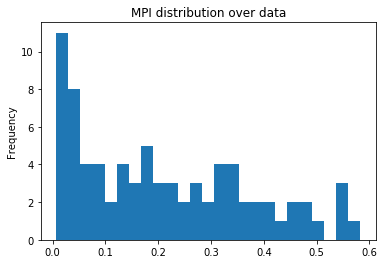

In [163]:
mpi_countries_df = pd.DataFrame(columns=["country", "avg_mpi", "std_mpi"])
mpi_countries_df["country"] = mpi_df["country"].unique() # last entry is nan
mpi_countries_df.set_index("country",inplace=True)
for country in mpi_countries_df.index:
    cmask = mpi_df["country"] == country
    mpi_countries_df.at[country,"avg_mpi"] = np.mean(mpi_df[cmask]["MPI"])
    mpi_countries_df.at[country,"std_mpi"] = np.std(mpi_df[cmask]["MPI"])
mpi_countries_df["avg_mpi"].plot.hist(bins=25,title="MPI distribution over data")

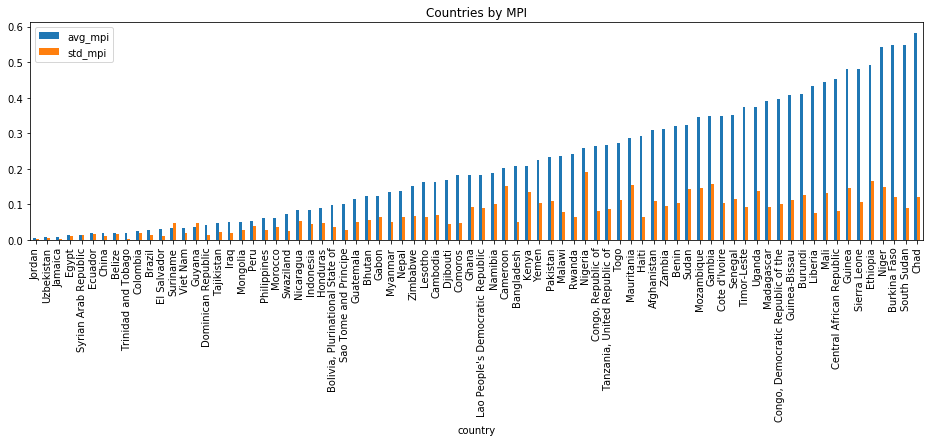

In [111]:
sorted_df = mpi_countries_df.sort_values(by="avg_mpi")
sorted_df.plot(kind="bar",title="Countries by MPI",figsize=(16,4))

I am not sure how to read the MPI... is hight better or worse? Judging by the countries, high is worse... Some countires like Suriname and Guyana have a surprisingly high standard deviation of their MPI, which could meand a lot of inequality by region (need more investigation).

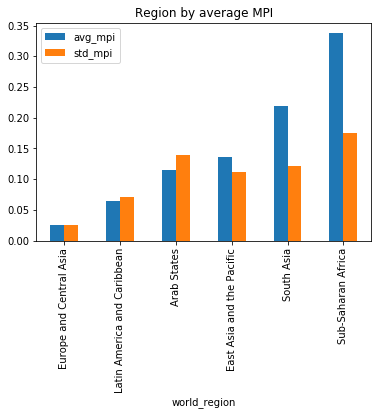

In [162]:
mpi_world_regions_df = pd.DataFrame(columns=["world_region", "avg_mpi", "std_mpi"])
mpi_world_regions_df["world_region"] = mpi_df["world_region"].unique()
mpi_world_regions_df.set_index("world_region",inplace=True)
for region in mpi_world_regions_df.index:
    rmask = mpi_df["world_region"] == region
    mpi_world_regions_df.at[region,"avg_mpi"] = np.mean(mpi_df[rmask]["MPI"])
    mpi_world_regions_df.at[region,"std_mpi"] = np.std(mpi_df[rmask]["MPI"])
mpi_world_regions_df.sort_values(by="avg_mpi").plot(kind="bar",title="Region by average MPI")

Interestingly, the lowest MPI regions seem to have the highest disparities between countries.

## loan_theme_ids
This file contains the them by loan id and the partner. The number of row is much higher than the kiva_loan table.

In [132]:
loan_by_id_df = pd.read_csv("data/02-kiva/loan_theme_ids.csv",index_col=0)
print(loan_by_id_df.shape)
loan_by_id_df.head()

(779092, 3)


,Loan Theme ID,Loan Theme Type,Partner ID
id,,,
638631,a1050000000skGl,General,151.0
640322,a1050000000skGl,General,151.0
641006,a1050000002X1ij,Higher Education,160.0
641019,a1050000002X1ij,Higher Education,160.0
641594,a1050000002VbsW,Subsistence Agriculture,336.0


Let's check the number of possible themes. Top 50 vs bottom 50 in numbers of loans.

(204, 1)


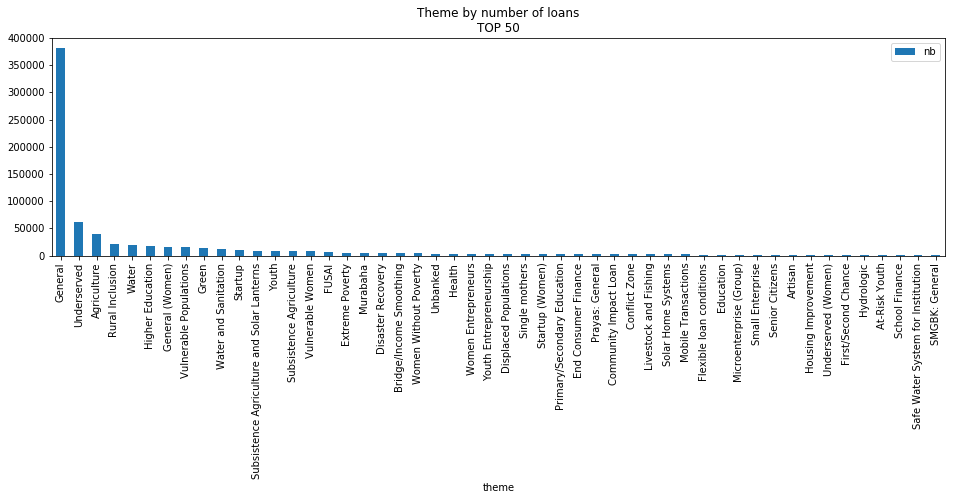

In [166]:
themes = loan_by_id_df["Loan Theme Type"].unique()
themes_df = pd.DataFrame(columns=["theme","nb"])
themes_df["theme"] = themes
themes_df.set_index("theme",inplace=True)
for theme in themes:
    themes_df.at[theme,"nb"] = np.sum(loan_by_id_df["Loan Theme Type"] == theme)
print(themes_df.shape)
themes_df.sort_values(by="nb",ascending=False).head(50).plot(kind="bar",figsize=(16,4),title="Theme by number of loans\nTOP 50")

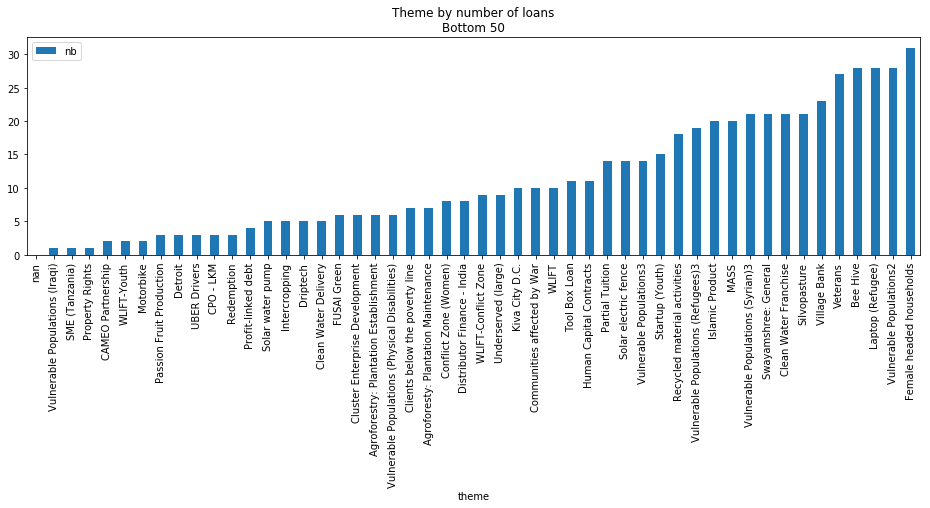

In [167]:
themes_df.sort_values(by="nb").head(50).plot(kind="bar",figsize=(16,4),title="Theme by number of loans\nBottom 50")

## loan_themes_by_region
The last file contains more detailed loan informations by partner_id, with 15.7k row of information.

In [149]:
loan_themes_by_region_df = pd.read_csv("data/02-kiva/loan_themes_by_region.csv",index_col=0)
print(loan_themes_by_region_df.shape)
loan_themes_by_region_df.head()

(15736, 20)


,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,number,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
Partner ID,,,,,,,,,,,,,,,,,,,,
9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,1,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,58,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,7,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,1383,604950,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,3,275,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0


There seem to be a lot of redondant geolocation information, which about the same information appearing in about 5 columns...

Let's check how close the theme distribution is from loan by id.

Nb unique theme = 170


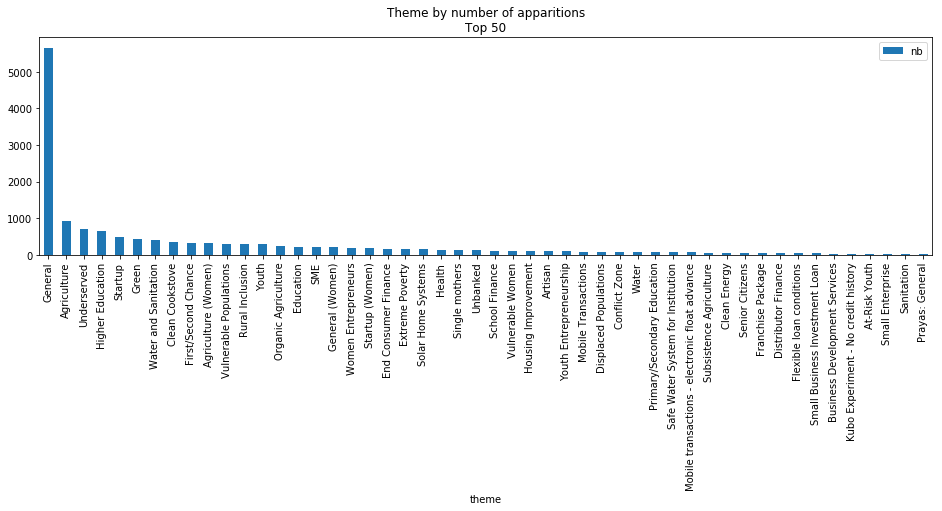

In [168]:
theme_types = loan_themes_by_region_df["Loan Theme Type"].unique()
print("Nb unique theme = %d" % len(theme_types))
theme_types_df = pd.DataFrame(columns=["theme","nb"])
theme_types_df["theme"] = theme_types
theme_types_df.set_index("theme",inplace=True)
for theme in theme_types:
    theme_types_df.at[theme,"nb"] = np.sum(loan_themes_by_region_df["Loan Theme Type"] == theme)
theme_types_df.sort_values(by="nb",ascending=False).head(50).plot(kind="bar",figsize=(16,4),title="Theme by number of apparitions\nTop 50")

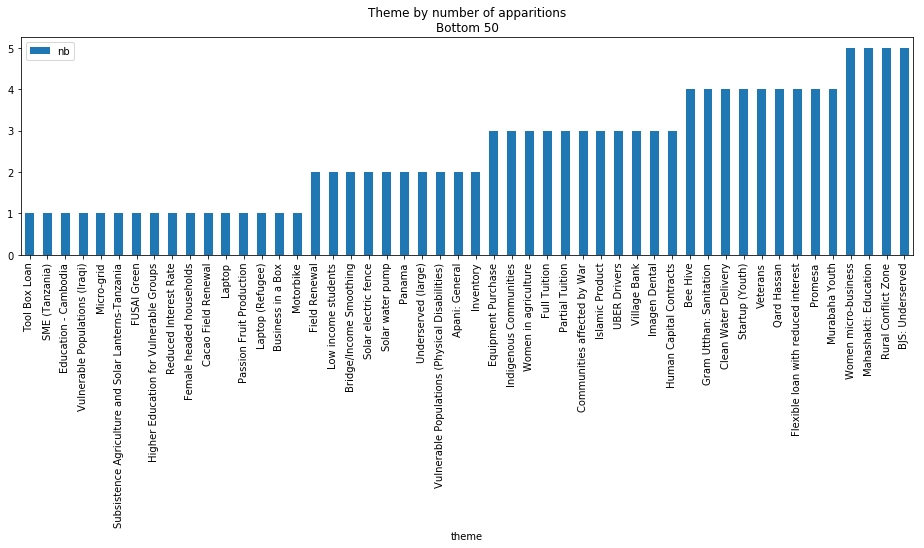

In [169]:
theme_types_df.sort_values(by="nb").head(50).plot(kind="bar",figsize=(16,4),title="Theme by number of apparitions\nBottom 50")

We see about the same themes in the first 50 (coherence between tables! Hurray!).

What about the number of sectors and partners?

In [186]:
sectors = loan_themes_by_region_df["sector"].unique()
partners = loan_themes_by_region_df.index.unique()
print("We have %d partners in %d sectors" % (len(partners),len(sectors)))

We have 302 partners in 11 sectors


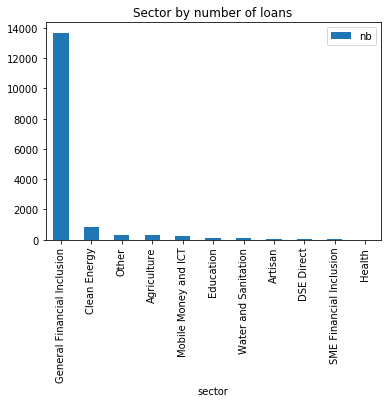

In [188]:
sector_df = pd.DataFrame(columns=["sector","nb"])
sector_df["sector"] = sectors
sector_df.set_index("sector",inplace=True)
for sector in sectors:
    sector_df.at[sector,"nb"] = np.sum(loan_themes_by_region_df["sector"] == sector)
sector_df.sort_values(by="nb",ascending=False).plot(kind="bar",title="Sector by number of loans")

And finally, the disparity in number of loan by partners. (Also want to see if I can show partners on a map)